In [101]:

# for basic operations
import numpy as np 
import pandas as pd 
from scipy import stats
from sklearn.model_selection import train_test_split

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns


# for preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# evaluation
from sklearn.metrics import f1_score, matthews_corrcoef,confusion_matrix,plot_confusion_matrix
# feature importance
from sklearn.inspection import permutation_importance


# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



In [3]:
class FileController:
    def readCsv(self,path):
        return pd.read_csv(path)
#     def writeCsv(self,df,path):
        
    

In [4]:
class PreprocessController:
    def nullKnnImputer(self,df_train,df_test):
        imputer = KNNImputer()
        imputer.fit(df_train)
        return pd.DataFrame(imputer.transform(df_train), columns = df_train.columns),pd.DataFrame(imputer.transform(df_test), columns = df_test.columns)

    def dropCol(self,df_train,df_test,col):
        return df_train.drop(col,axis=1),df_test.drop(col,axis=1)
        
    


In [5]:

class EdaController:
    '''
    데이터 프레임을 설명에 쓰이는 클래스.(does not modify df)
    '''

        

        
        
    def summary(self,df, pred=None):
        obs = df.shape[0]
        Types = df.dtypes
        Counts = df.apply(lambda x: x.count())
        Min = df.min()
        Max = df.max()
        Uniques = df.apply(lambda x: x.unique().shape[0])
        Nulls = df.apply(lambda x: x.isnull().sum())
        print('Data shape:', df.shape)

        if pred is None:
            cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
            st = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

        st.columns = cols
        print('___________________________\nData Types:')
        print(st.Types.value_counts())
        print('___________________________')
        return st
    
    def imbalancedVisual(self,ser):
        labels = ['Pass', 'Fail']
        size = ser.value_counts()
        colors = ['blue', 'green']
        explode = [0, 0.1]

        plt.style.use('seaborn-deep')
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
        plt.axis('off')
        plt.title('Target: Pass or Fail', fontsize = 20)
        plt.legend()
        plt.show()
        # plt.bar(2,ser.value_counts())
        ser.value_counts().plot(kind="bar", color=['b','g'])
        plt.show()
    
    def checkUniqueValueColWithRawData(self,df,fillNull=True):
        temp = df.apply(lambda x: x.unique().shape[0])
        temp2 = df.fillna(method='ffill').apply(lambda x: x.unique().shape[0])
        print('1 unique vaule:',len(temp[temp.isin([1])]),'개')
        print('1 unique vaule + null :',len(temp2[temp2.isin([1])]),'개')

        if fillNull:
            return list(temp2[temp2.isin([1])].index)
        else:
            return list(temp[temp.isin([1])].index)
         


    def checkNull(self,df,percent=None):
        '''
        return list of index which has greater missing percentage if percent value is passed. 
        '''
        missPercentTable = df.isnull().sum()/df.shape[0]*100
        for n in range(10,100,10):
            print(f'missing {n}~{n+10}%: {len([i for i,p in enumerate(missPercentTable) if p>=n and p<n+10 ])}개')
        if percent:
            return [i for i,p in missPercentTable.iteritems() if p<percent and p>=10 ],[i for i,p in missPercentTable.iteritems() if p>=percent ]

    def correlation(self,dataset, threshold):
        col_corr = set()  # Set of all the names of correlated columns
        corr_matrix = dataset.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    col_corr.add(colname)
        return col_corr
        
    

In [168]:
class ModelingController:

    def logisticEvaluate(self,train_df, test_df, train_target, test_target):

        model_order = ['Logistic Regression','RandomForest']
        lr_score = []
        rf_score = []


        lr_coef = []
        rf_coef = []

    
        # first, we should scale our data so logistic regression works better
        scaler = RobustScaler()
        scaler.fit(train_df)
        train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
        test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

        y_train_true = train_target.values.ravel()
        y_test_true = test_target.values.ravel()

        ## Logistic Regression
        # training the model
        logreg = LogisticRegression()
        rf = RandomForestClassifier(n_estimators=5,random_state=0,max_depth=12,n_jobs=-1)


        for i,clf in enumerate([logreg,rf]):
            # start_time = datetime.datetime.now()
            clf.fit(train_std, train_target.values.ravel())
            # elapsed = datetime.datetime.now() - start_time
            # time = int(elapsed.total_seconds()*1000)
            # evaluation and scoring
            y_train_pred = clf.predict(train_std)
            y_test_pred = clf.predict(test_std)

            # f1score_train = f1_score(y_train_true, y_train_pred, average='micro')
            f1score_test = f1_score(y_test_true, y_test_pred, average='micro')
            # mccscore_train=matthews_corrcoef(y_train_true, y_train_pred)
            mccscore_test=matthews_corrcoef(y_test_true, y_test_pred)
            cm =confusion_matrix(y_test_true,y_test_pred)
            tn,fp,fn,tp = cm.ravel()
            fpr = fp/(fp+tn)
            sns.heatmap(cm,annot=True,cmap='Blues')
            plt.xlabel('Predicted Value',fontsize=15)
            plt.ylabel('True Value',fontsize=15)
            plt.show()
            if i ==0:
                lr_score.extend([f1score_test,mccscore_test,fpr])
                t1_df = pd.DataFrame([list(map(abs,clf.coef_))[0],clf.coef_[0]],columns=list(train_std.columns))
                t1_df = t1_df.T.sort_values(by=0,ascending=False).drop([0],axis=1)

               

            else:
                rf_score.extend([f1score_test,mccscore_test,fpr])
 
                imp = clf.feature_importances_

                t3_df = pd.DataFrame([list(map(abs,imp)),imp],columns=list(train_std.columns))
                t3_df = t3_df.T.sort_values(by=0,ascending=False).drop([0],axis=1)

            del y_train_pred, y_test_pred
        imp_result = pd.DataFrame([t1_df.index,t3_df.index],index=model_order).transpose()
        display(imp_result)

        
        result = pd.DataFrame([lr_score,rf_score],index=model_order,columns=['f1','mcc','fpr'])
        display(result)
        # print(result)

        # plot.ax_.set_title('Confusion Matrix')
        # rocauc = plot_roc_curve(logreg, test_std, y_true)
        # plt.show()
        # print('Logistic Regression Evaluation')
        # print(f' F1 Score: {f1score_test}')
        # print(f' MCC Score: {mccscore_test}')
        # print(f' Training time: {time}ms\n F1 Score: {f1score_test}\n MCC Score: {mccscore_test}')
        return imp_result ,result

# Initailize Class

In [91]:
#class initialize
fController = FileController()
eController = EdaController()
pController = PreprocessController()
mController = ModelingController()

# Load Data Frame & Split Data

In [8]:
# load csv file
rawData = fController.readCsv('./uci-secom.csv')

In [9]:
X = rawData.iloc[:,:-1]
y = rawData.iloc[:,-1]
# 종속변수 1,0으로 변환
y=y.replace(1,0)
y=y.replace(-1,1)
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=0)

# EDA

# 1. Summary

In [10]:
summaryTable = eController.summary(df=rawData)
display(summaryTable)

Data shape: (1567, 592)
___________________________
Data Types:
float64    590
int64        1
object       1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
0,float64,1561,1521,6,2743.24,3356.35
1,float64,1560,1505,7,2158.75,2846.44
10,float64,1565,393,2,-0.0349,0.053
100,float64,1561,36,6,-0.003,0.0023
101,float64,1561,30,6,-0.0024,0.0017
...,...,...,...,...,...,...
97,float64,1561,2,6,0,0
98,float64,1561,1421,6,-5.2717,2.5698
99,float64,1561,273,6,-0.5283,0.8854
Pass/Fail,int64,1567,2,0,-1,1


In [11]:
# drop time
X_train,X_test = pController.dropCol(X_train,X_test,['Time'])
X_train.shape,X_test.shape

((1253, 590), (314, 590))

## 1.1 Imbalaced Target

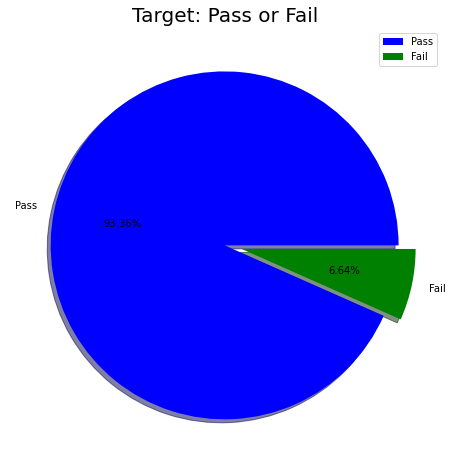

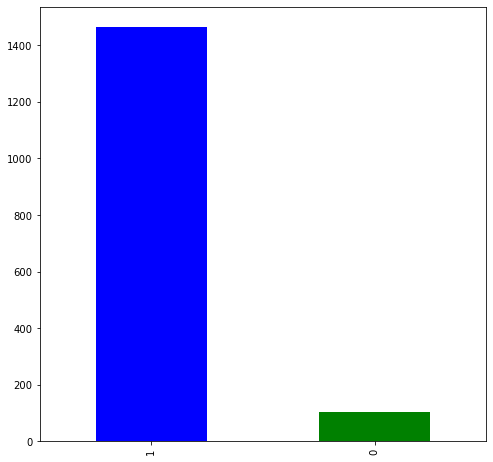

In [12]:
eController.imbalancedVisual(y)

# 2. Null Handling

## 2.1 Null Check

In [13]:
# missing value percentage
missingCol,dropCol = eController.checkNull(df=X_train,percent = 20)

# 20% 이상 NUll 값이 존재하면 drop 

missing 10~20%: 20개
missing 20~30%: 0개
missing 30~40%: 0개
missing 40~50%: 4개
missing 50~60%: 4개
missing 60~70%: 16개
missing 70~80%: 0개
missing 80~90%: 4개
missing 90~100%: 4개


In [14]:
# drop 
X_train = X_train.drop(dropCol,axis=1)
X_test = X_test.drop(dropCol,axis=1)
X_train.shape,X_test.shape

((1253, 558), (314, 558))

## 2.2 Fill Null value

### 2.2.1 KNN Imputer (App.1)

### 2.2.2 mean value

In [15]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
# mController.logisticEvaluate(X_train,X_test,y_train,y_test)


In [16]:
full_train = X_train
full_test = X_test

In [17]:
full_train.shape

(1253, 558)

## 1.2 Number of Unique Value

In [18]:
uniqueColWithNull = eController.checkUniqueValueColWithRawData(X_train,True)
len(uniqueColWithNull)

1 unique vaule: 116 개
1 unique vaule + null : 116 개


116

In [19]:
# unique vaule + null drop 
X_train = X_train.drop(uniqueColWithNull,axis=1)
X_test = X_test.drop(uniqueColWithNull,axis=1)
X_train.shape,X_test.shape
cleansed_train = X_train
cleansed_test = X_test


0      1222
1      1213
2       480
3       487
4       475
       ... 
585    1218
586     303
587     246
588     117
589     533
Length: 442, dtype: int64



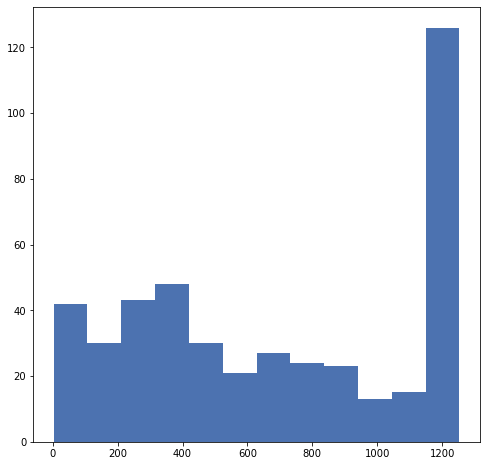

In [20]:
# unique value histogram
temp = pd.Series(X_train.nunique())
print(temp)
print()
plt.hist(temp,bins = 12,label='Num of Unique values')
plt.show()

In [21]:
'''# unique val: 55개
colNum = [i for i,val in X_train.nunique().iteritems() if val ==61 ]
print(X_train.loc[:,colNum[0]].describe())
print()
print('value counts')
X_train.loc[:,colNum[0]].hist()

'''

"# unique val: 55개\ncolNum = [i for i,val in X_train.nunique().iteritems() if val ==61 ]\nprint(X_train.loc[:,colNum[0]].describe())\nprint()\nprint('value counts')\nX_train.loc[:,colNum[0]].hist()\n\n"

count    1253.000000
mean       11.264291
std       102.349758
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1000.000000
Name: 521, dtype: float64

value counts
0.0000       1237
1000.0000      11
907.9100        1
776.2169        1
158.2158        1
718.6040        1
553.2097        1
Name: 521, dtype: int64


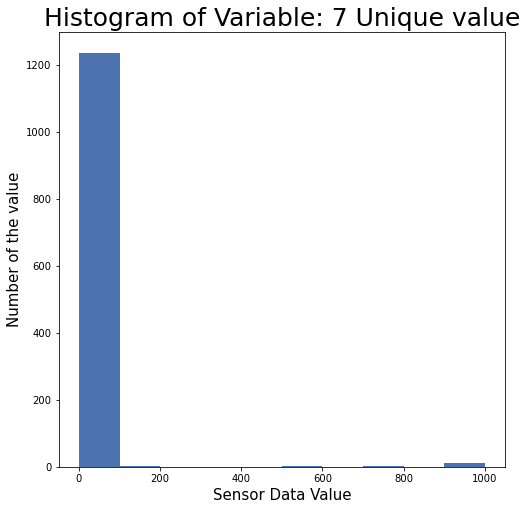

In [31]:
# unique val: 7개
colNum = [i for i,val in cleansed_train.nunique().iteritems() if val ==7 ]
print(cleansed_train.loc[:,colNum[0]].describe())
print()
print('value counts')
print(cleansed_train.loc[:,colNum[0]].value_counts())
plt.hist(cleansed_train.loc[:,colNum[0]])
plt.title('Histogram of Variable: 7 Unique value',fontsize=25)
plt.xlabel('Sensor Data Value',fontsize=15)
plt.ylabel('Number of the value',fontsize=15)
plt.show()



In [ ]:
'''# unique val: 13개
colNum = [i for i,val in X_train.nunique().iteritems() if val ==14]
print(X_train.loc[:,colNum[0]].describe())
print()
print('value counts')
print(X_train.loc[:,colNum[0]].value_counts())

X_train.loc[:,colNum[0]].hist(bins=14)
'''

"# unique val: 13개\ncolNum = [i for i,val in X_train.nunique().iteritems() if val ==14]\nprint(X_train.loc[:,colNum[0]].describe())\nprint()\nprint('value counts')\nprint(X_train.loc[:,colNum[0]].value_counts())\n\nX_train.loc[:,colNum[0]].hist(bins=14)\n"

### Drop Unique Val under 100
## TODO: 10 으로 내리고 10~100 수작업 전처리

In [39]:
thCol = [i for i,val in X_train.nunique().iteritems() if val <=100]
X_train,X_test = pController.dropCol(X_train,X_test,thCol)
print(X_train.shape, X_test.shape)
a,b =mController.logisticEvaluate(X_train,X_test,y_train,y_test)
reduced_train = X_train
reduced_test = X_test

(1253, 402) (314, 402)


,Logistic Regression,Gaussian Naive Bayes,RandomForest,SVM Classifier
0,499,577,59,56
1,132,275,426,132
2,59,290,571,563
3,31,428,348,61
4,484,140,553,333
...,...,...,...,...
397,344,550,302,525
398,156,554,304,444
399,250,354,305,36
400,525,556,306,34


,f1_train,f1_test,mcc_train,mcc_test
Logistic Regression,0.944932,0.926752,0.485731,0.041957
Gaussian Naive Bayes,0.252993,0.162420,0.102539,-0.054267
RandomForest,0.961692,0.958599,0.673634,0.184308
SVM Classifier,0.996808,0.853503,0.976096,0.023212


In [40]:
a.iloc[:,[0,2]].head(22)

,Logistic Regression,RandomForest
0,499,59
1,132,426
2,59,571
3,31,348
4,484,553
5,485,282
6,56,539
7,545,439
8,548,153
9,125,64


### Ranksum 2 test

In [41]:
ranksum_col = []
tempData = X_train.merge(y_train,left_index=True,right_index=True)
passData = tempData[tempData['Pass/Fail']==1]
failData = tempData[tempData['Pass/Fail']==0]
colList = list(X_train.columns)
for i in colList:
    pValue = stats.ranksums(passData[i],failData[i]).pvalue
    
    if pValue>0.05:
        ranksum_col. append(i)
print(len(ranksum_col)) 
X_train,X_test = pController.dropCol(X_train,X_test,ranksum_col)
t_train = X_train
t_test = X_test
X_train.shape,X_test.shape

331


((1253, 71), (314, 71))

In [46]:
len(ranksum_col)

331

In [42]:

mController.logisticEvaluate(X_train,X_test,y_train,y_test)

,Logistic Regression,Gaussian Naive Bayes,RandomForest,SVM Classifier
0,183,573,210,455
1,455,577,59,183
2,420,575,14,282
3,180,290,40,477
4,452,135,573,420
...,...,...,...,...
66,127,279,135,213
67,425,455,126,582
68,133,336,577,133
69,135,180,78,28


,f1_train,f1_test,mcc_train,mcc_test
Logistic Regression,0.936951,0.926752,0.360637,0.110016
Gaussian Naive Bayes,0.454908,0.372611,0.170324,-0.009317
RandomForest,0.980048,0.945860,0.842615,0.087762
SVM Classifier,0.928970,0.958599,0.142879,0.000000


(   Logistic Regression Gaussian Naive Bayes RandomForest SVM Classifier
 0                  183                  573          210            455
 1                  455                  577           59            183
 2                  420                  575           14            282
 3                  180                  290           40            477
 4                  452                  135          573            420
 ..                 ...                  ...          ...            ...
 66                 127                  279          135            213
 67                 425                  455          126            582
 68                 133                  336          577            133
 69                 135                  180           78             28
 70                  28                  144          180            103
 
 [71 rows x 4 columns],
                       f1_train   f1_test  mcc_train  mcc_test
 Logistic Regression   0.936951  0.

## 3. Multicollinearity (VIF)

In [47]:
len(vifDropCol)

49

In [43]:
#calculate Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
condition = 1
temp_train = X_train
vifDropCol = []
while condition !=0:

    vif_scores = pd.DataFrame() 

    vif_scores["Attribute"] = temp_train.columns 
    # calculating VIF for each feature 
    vif_scores["VIF Scores"] = [variance_inflation_factor(temp_train.values, i) for i in range(len(temp_train.columns))] 
    condition = (vif_scores['VIF Scores']>10).sum()
    droppingCol = vif_scores['Attribute'][vif_scores['VIF Scores'].idxmax()]
    vifDropCol.append(droppingCol)
    temp_train =temp_train.drop([droppingCol],axis=1)

display(vif_scores)

,Attribute,VIF Scores
0,14,9.426723
1,40,7.803079
2,59,2.103786
3,78,1.340581
4,79,1.440615
5,102,1.023081
6,135,5.592756
7,200,6.021445
8,213,2.832006
9,279,5.184672


In [44]:
X_train ,X_test= pController.dropCol(X_train,X_test,vifDropCol)
f_train,f_test = X_train,X_test

In [45]:
mController.logisticEvaluate(X_train,X_test,y_train,y_test)

,Logistic Regression,Gaussian Naive Bayes,RandomForest,SVM Classifier
0,511,295,59,577
1,59,434,348,200
2,577,468,102,213
3,102,59,510,511
4,348,348,477,282
5,460,79,425,295
6,135,40,200,78
7,510,282,79,428
8,200,200,468,135
9,78,510,78,467


,f1_train,f1_test,mcc_train,mcc_test
Logistic Regression,0.926576,0.958599,0.079845,0.184308
Gaussian Naive Bayes,0.830806,0.818471,0.193743,0.117107
RandomForest,0.973663,0.958599,0.787250,0.184308
SVM Classifier,0.927374,0.958599,0.000000,0.000000


(   Logistic Regression Gaussian Naive Bayes RandomForest SVM Classifier
 0                  511                  295           59            577
 1                   59                  434          348            200
 2                  577                  468          102            213
 3                  102                   59          510            511
 4                  348                  348          477            282
 5                  460                   79          425            295
 6                  135                   40          200             78
 7                  510                  282           79            428
 8                  200                  200          468            135
 9                   78                  510           78            467
 10                 428                  467          279             59
 11                 279                  511          434            510
 12                 213                  279       

In [ ]:
# sns.pairplot(temp_train)

In [ ]:
# sns.heatmap(temp_train)

In [ ]:
X_train = temp_train
X_test = temp_test

## Oversampling (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
a,b = mController.logisticEvaluate(X_train_over,X_test,y_train_over,y_test)


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1253, 22) (1253,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2324, 22) (2324,)
SMOTE 적용 후 레이블 값 분포: 
 1    1162
0    1162
Name: Pass/Fail, dtype: int64


,Logistic Regression,Gaussian Naive Bayes,RandomForest,SVM Classifier
0,59,428,59,59
1,511,577,40,511
2,348,135,428,510
3,102,59,510,200
4,510,279,460,102
5,200,468,468,348
6,135,295,434,460
7,577,348,348,135
8,468,79,135,468
9,460,510,467,577


,f1_train,f1_test,mcc_train,mcc_test
Logistic Regression,0.727625,0.710191,0.455298,0.080389
Gaussian Naive Bayes,0.631670,0.321656,0.336677,0.031126
RandomForest,0.997418,0.885350,0.994850,0.099351
SVM Classifier,0.730637,0.694268,0.461274,0.103245


In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=22)
X_train_over, y_train_over = adasyn.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
mController.logisticEvaluate(X_train_over,X_test,y_train_over,y_test)


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1253, 22) (1253,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2316, 22) (2316,)
SMOTE 적용 후 레이블 값 분포: 
 1    1162
0    1154
Name: Pass/Fail, dtype: int64


,Logistic Regression,Gaussian Naive Bayes,RandomForest,SVM Classifier
0,59,428,59,59
1,511,135,428,511
2,348,577,468,102
3,102,348,102,348
4,200,59,40,510
5,510,468,348,200
6,577,279,460,460
7,135,79,425,577
8,460,78,510,135
9,428,510,577,477


,f1_train,f1_test,mcc_train,mcc_test
Logistic Regression,0.743523,0.707006,0.487095,0.078667
Gaussian Naive Bayes,0.632988,0.315287,0.338210,0.028412
RandomForest,0.996978,0.869427,0.993973,0.167962
SVM Classifier,0.753022,0.726115,0.506043,0.089260


(   Logistic Regression Gaussian Naive Bayes RandomForest SVM Classifier
 0                   59                  428           59             59
 1                  511                  135          428            511
 2                  348                  577          468            102
 3                  102                  348          102            348
 4                  200                   59           40            510
 5                  510                  468          348            200
 6                  577                  279          460            460
 7                  135                   79          425            577
 8                  460                   78          510            135
 9                  428                  510          577            477
 10                 477                  511          467            468
 11                  78                  295          200            213
 12                  79                  213       

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train_over,y_train_over = smoteto.fit_resample(X_train,y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
mController.logisticEvaluate(X_train_over,X_test,y_train_over,y_test)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1253, 22) (1253,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2308, 22) (2308,)
SMOTE 적용 후 레이블 값 분포: 
 1    1162
0    1146
Name: Pass/Fail, dtype: int64


,Logistic Regression,Gaussian Naive Bayes,RandomForest,SVM Classifier
0,59,428,59,59
1,511,135,40,348
2,348,468,468,511
3,102,577,460,510
4,510,279,102,102
5,200,348,510,200
6,135,59,428,460
7,460,295,295,135
8,78,79,200,78
9,79,434,348,468


,f1_train,f1_test,mcc_train,mcc_test
Logistic Regression,0.759965,0.735669,0.519919,0.094809
Gaussian Naive Bayes,0.622617,0.321656,0.311906,0.031126
RandomForest,0.996967,0.872611,0.993952,0.171962
SVM Classifier,0.767764,0.732484,0.535497,0.092939


(   Logistic Regression Gaussian Naive Bayes RandomForest SVM Classifier
 0                   59                  428           59             59
 1                  511                  135           40            348
 2                  348                  468          468            511
 3                  102                  577          460            510
 4                  510                  279          102            102
 5                  200                  348          510            200
 6                  135                   59          428            460
 7                  460                  295          295            135
 8                   78                   79          200             78
 9                   79                  434          348            468
 10                 577                  282          467            477
 11                 279                  510          477            279
 12                 468                  460       

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
X_train_over, y_train_over = BorderlineSMOTE().fit_resample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
mController.logisticEvaluate(X_train_over,X_test,y_train_over,y_test)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1253, 22) (1253,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2324, 22) (2324,)
SMOTE 적용 후 레이블 값 분포: 
 1    1162
0    1162
Name: Pass/Fail, dtype: int64


,Logistic Regression,Gaussian Naive Bayes,RandomForest,SVM Classifier
0,59,428,40,59
1,511,135,59,511
2,348,577,468,348
3,510,348,460,510
4,102,59,348,102
5,200,468,200,200
6,135,511,102,460
7,78,295,510,135
8,460,434,467,477
9,79,79,477,79


,f1_train,f1_test,mcc_train,mcc_test
Logistic Regression,0.756024,0.745223,0.512281,0.100549
Gaussian Naive Bayes,0.607143,0.270701,0.291258,0.008483
RandomForest,0.998279,0.853503,0.996564,0.109247
SVM Classifier,0.757315,0.748408,0.514905,0.102509


(   Logistic Regression Gaussian Naive Bayes RandomForest SVM Classifier
 0                   59                  428           40             59
 1                  511                  135           59            511
 2                  348                  577          468            348
 3                  510                  348          460            510
 4                  102                   59          348            102
 5                  200                  468          200            200
 6                  135                  511          102            460
 7                   78                  295          510            135
 8                  460                  434          467            477
 9                   79                   79          477             79
 10                 577                  510          434             78
 11                 428                  279          511            428
 12                 477                   40       

In [ ]:
a,b=mController.logisticEvaluate(temp_train,temp_test,y_train,y_test)


,Logistic Regression,Gaussian Naive Bayes,RandomForest,SVM Classifier
0,511,295,59,577
1,59,434,348,200
2,577,348,279,213
3,102,40,477,511
4,348,467,102,282
5,460,59,40,295
6,135,282,200,78
7,510,510,577,428
8,200,468,295,135
9,78,79,510,467


,f1_train,f1_test,mcc_train,mcc_test
Logistic Regression,0.926576,0.958599,0.079845,0.184308
Gaussian Naive Bayes,0.830806,0.818471,0.193743,0.117107
RandomForest,0.996808,0.942675,0.976096,0.221245
SVM Classifier,0.927374,0.958599,0.000000,0.000000


In [ ]:
sc_=[]
for j in range(21):
    x_col = list(X_train.columns)
    surv_col = list(a.iloc[:j,0].values)
    drop_col = [i for i in x_col if i not in surv_col]
    r_train,r_test = pController.dropCol(X_train,X_test,drop_col)
    c,d = mController.logisticEvaluate(r_train,r_test,y_train,y_test)
    sc_.append(d.iloc[0,3])



ValueError: at least one array or dtype is required

## 3. T-test

### 3.1 정규성 검정 (Shapiro-Wilk Test)

In [32]:
#샤피로-윌크 검정(Shapiro–Wilk test) 
for i in range(100):
    temp = cleansed_train.iloc[:,i]
    print(stats.shapiro(temp))


ShapiroResult(statistic=0.977893054485321, pvalue=6.319921799433081e-13)
ShapiroResult(statistic=0.9713311791419983, pvalue=4.6783052692206395e-15)
ShapiroResult(statistic=0.9810818433761597, pvalue=9.802641337541829e-12)
ShapiroResult(statistic=0.8656734824180603, pvalue=1.893632414252348e-31)
ShapiroResult(statistic=0.032211244106292725, pvalue=0.0)
ShapiroResult(statistic=0.9569013714790344, pvalue=9.21721773098704e-19)
ShapiroResult(statistic=0.17377668619155884, pvalue=0.0)
ShapiroResult(statistic=0.9959288835525513, pvalue=0.002051972784101963)
ShapiroResult(statistic=0.9903824925422668, pvalue=2.606296334306535e-07)
ShapiroResult(statistic=0.987284243106842, pvalue=5.447852391426977e-09)
ShapiroResult(statistic=0.6149930953979492, pvalue=0.0)
ShapiroResult(statistic=0.6915963292121887, pvalue=6.305843089461677e-43)
ShapiroResult(statistic=0.9947563409805298, pvalue=0.00023041683016344905)
ShapiroResult(statistic=0.9351636171340942, pvalue=6.403149888887847e-23)
ShapiroResult(sta

In [37]:
# 콜모고로프-스미르노프 검정(Kolmogorov-Smirnov test) 
import statsmodels.stats.diagnostic as smd
for i in range(100):
    temp = cleansed_train.iloc[:,i]
    print(smd.kstest_normal(temp, pvalmethod='approx',dist='norm'))
# 정규성 불만족

(0.04546285024669838, 2.2881945118366433e-06)
(0.05548098804314583, 1.1087013938914663e-09)
(0.03738494808266979, 0.00030700801870800476)
(0.11822497489983824, 1.8268719054272058e-47)
(0.4996094647482186, 0.0)
(0.08022224868793759, 4.487910606570141e-21)
(0.3327631613619565, 0.0)
(0.023868056893032286, 0.09099023038056821)
(0.03241508428005824, 0.0035841047585999566)
(0.03717684564359741, 0.0003431884602491755)
(0.1068607553437585, 1.9150516776204924e-38)
(0.09306400251731332, 8.691765459444811e-29)
(0.013737158241004799, 0.8849494876819223)
(0.030718862058125462, 0.007524311805710546)
(0.35972462497735347, 0.0)
(0.19558110638156578, 1.857149650301323e-134)
(0.06785335156714278, 8.28418937957524e-15)
(0.2871984482163812, 3.2649794202696403e-295)
(0.05487370768621497, 1.849498257313417e-09)
(0.15006073870705305, 7.304150783764381e-78)
(0.14937877005985656, 3.926113633066072e-77)
(0.13155524806870378, 2.8393295092202098e-59)
(0.15598897789514232, 2.334891779197028e-84)
(0.322618303560103

# Appendix

### App.1 KNN Imputer

In [ ]:
imputed_train, imputed_test = pController.nullKnnImputer(X_train,X_test)
imputed_train.shape, imputed_test.shape
eController.checkNull(imputed_train)
mController.logisticEvaluate(imputed_train,imputed_test,y_train,y_test)


missing 10~20%: 0개
missing 20~30%: 0개
missing 30~40%: 0개
missing 40~50%: 0개
missing 50~60%: 0개
missing 60~70%: 0개
missing 70~80%: 0개
missing 80~90%: 0개
missing 90~100%: 0개


KeyboardInterrupt: 

## unique value handling

In [ ]:
cleansed_train.shape,cleansed_test.shape

((1253, 442), (314, 442))

In [ ]:
temp_train = cleansed_train
temp_test = cleansed_test

In [ ]:
col = [idx for idx, val in temp_train.nunique().sort_values().iteritems() if val<50]
len(col)

20

In [ ]:
(temp_train.nunique()<100)

0      False
1      False
2      False
3      False
4      False
       ...  
585    False
586    False
587    False
588    False
589    False
Length: 442, dtype: bool

# 선행논문

## 1. Predictive Models for Equipment Fault Detection in the Semiconductor Manufacturing Process

In [ ]:
print(full_train.shape)
print(cleansed_train.shape)
print(reduced_train.shape)
print(t_train.shape)
print(full_train.shape)

(1253, 558)
(1253, 442)
(1253, 402)
(1253, 558)
(1253, 558)


0


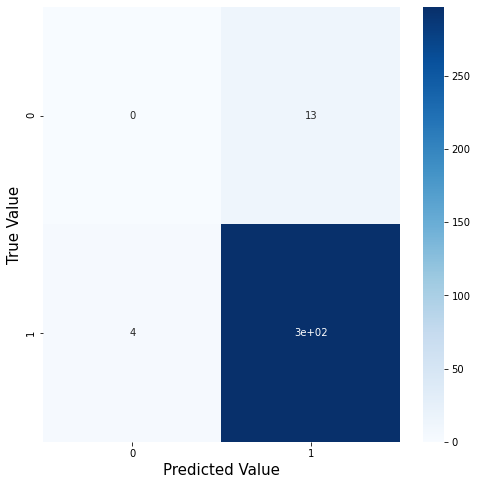

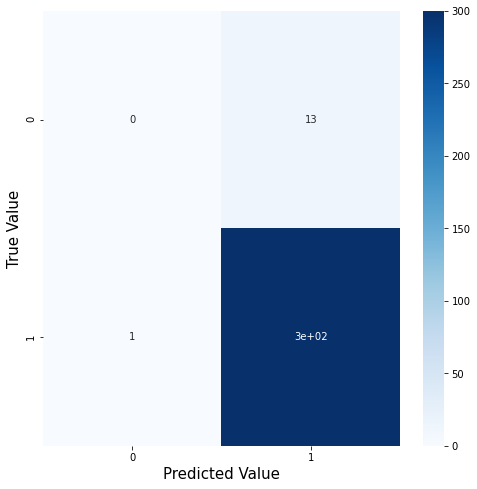

,f1,mcc,fpr
Logistic Regression,0.945860,-0.023607,1.0
RandomForest,0.955414,-0.011747,1.0


1


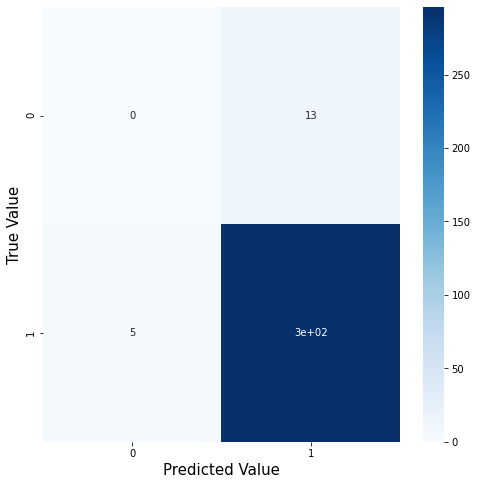

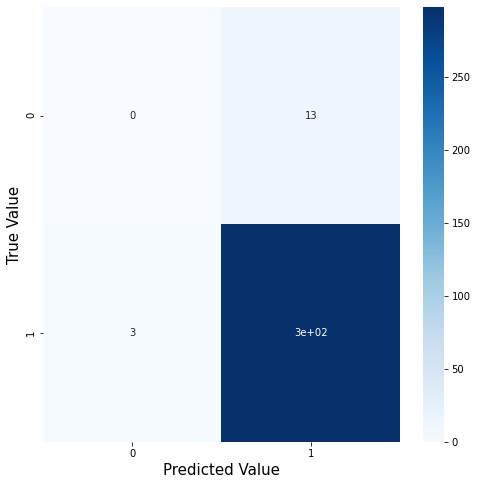

,f1,mcc,fpr
Logistic Regression,0.942675,-0.026436,1.0
RandomForest,0.949045,-0.020411,1.0


2


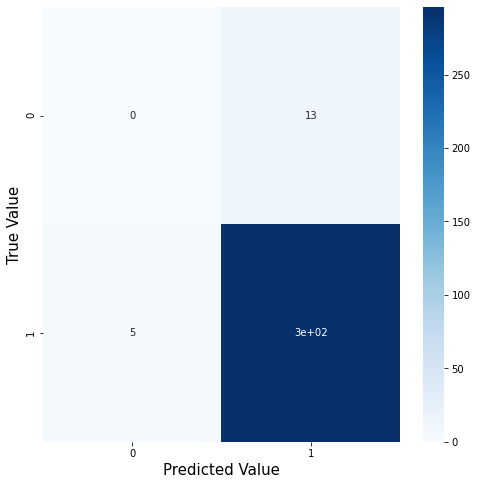

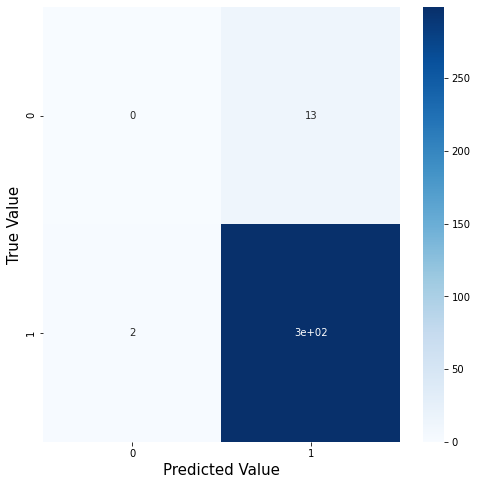

,f1,mcc,fpr
Logistic Regression,0.942675,-0.026436,1.0
RandomForest,0.952229,-0.016639,1.0


3


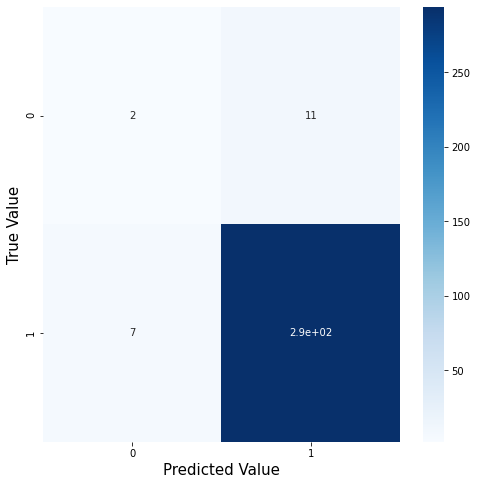

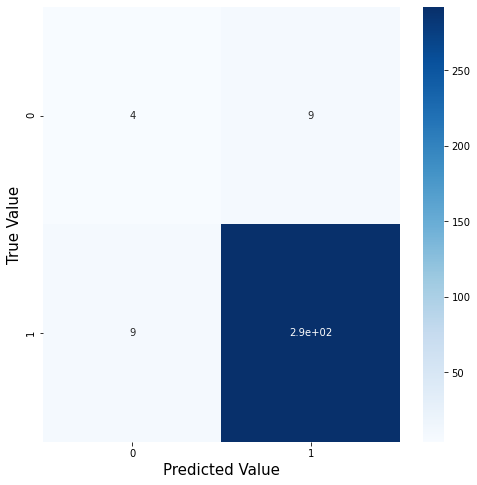

,f1,mcc,fpr
Logistic Regression,0.942675,0.155917,0.846154
RandomForest,0.942675,0.277792,0.692308


4


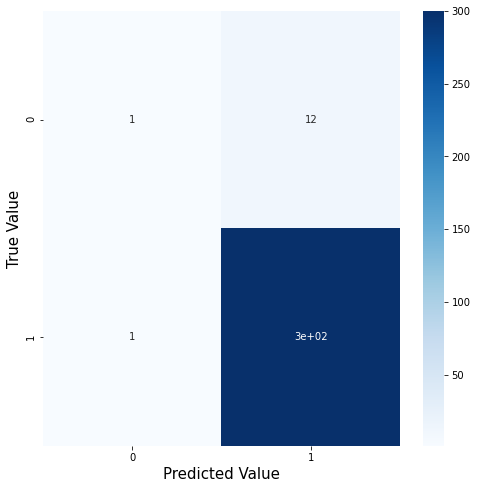

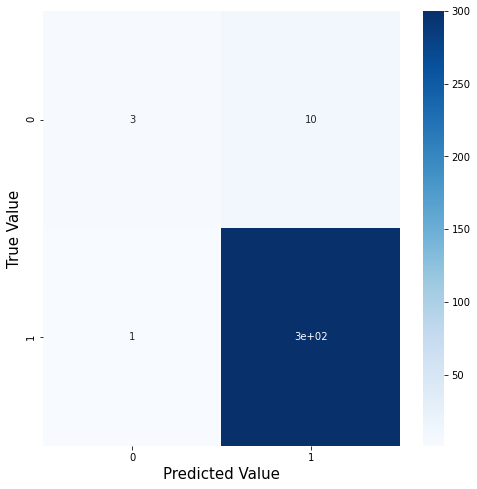

,f1,mcc,fpr
Logistic Regression,0.958599,0.184308,0.923077
RandomForest,0.964968,0.404040,0.769231


In [169]:
mController = ModelingController()

train_list = [full_train,cleansed_train,reduced_train,t_train,f_train]
test_list = [full_test,cleansed_test,reduced_test,t_test,f_test]

for i in range(len(train_list)):
    print(i)
    c,d  = mController.logisticEvaluate(train_list[i],test_list[i],y_train,y_test)

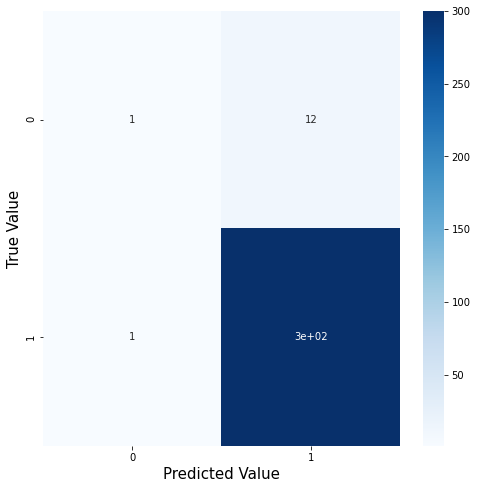

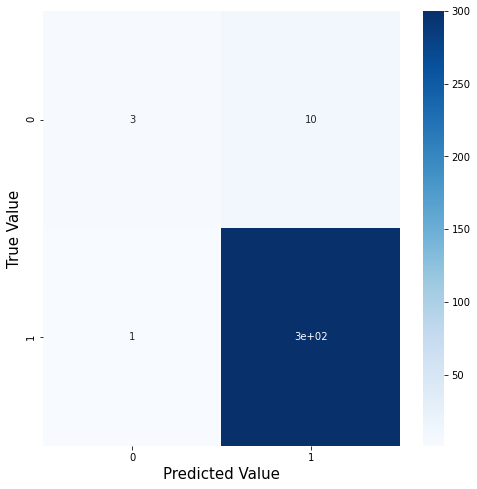

,f1,mcc,fpr
Logistic Regression,0.958599,0.184308,0.923077
RandomForest,0.964968,0.404040,0.769231


(   Logistic Regression RandomForest
 0                  511           59
 1                   59          102
 2                  577          348
 3                  102          477
 4                  348           40
 5                  460          425
 6                  135          434
 7                  510          200
 8                  200          511
 9                  428          467
 10                  78          510
 11                 279          279
 12                 213          295
 13                 477          213
 14                 282          428
 15                  79           78
 16                 467          468
 17                 468          577
 18                 425          282
 19                 295          460
 20                 434           79
 21                  40          135,
                            f1       mcc       fpr
 Logistic Regression  0.958599  0.184308  0.923077
 RandomForest         0.964968  0.404040  0.76

In [171]:
mController.logisticEvaluate(f_train,f_test,y_train,y_test)

In [ ]:
len(y_train)

1253

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
y_1 = pd.Series([1]*1253).ravel()

In [ ]:
f1_score(y_train,y_1)

0.9623188405797102

In [ ]:
f1_score(y_test,pd.Series([1]*len(y_test)))

0.9788617886178862

In [80]:
b

array([[  1,  12],
       [  1, 300]], dtype=int64)

In [85]:
b

array([[  1,  12],
       [  1, 300]], dtype=int64)

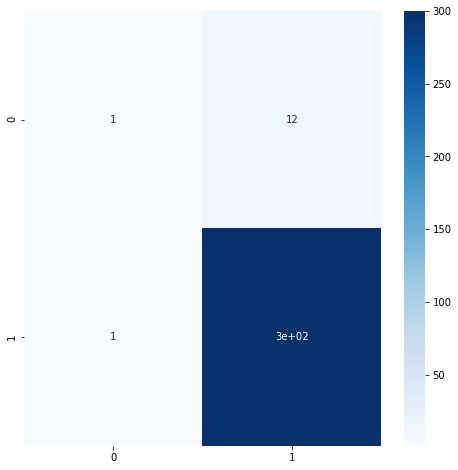

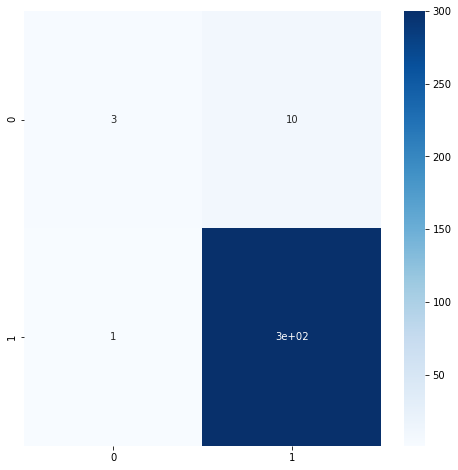

,f1,mcc,fpr
Logistic Regression,0.958599,0.184308,0.923077
RandomForest,0.964968,0.404040,0.769231


(   Logistic Regression RandomForest
 0                  511           59
 1                   59          102
 2                  577          348
 3                  102          477
 4                  348           40
 5                  460          425
 6                  135          434
 7                  510          200
 8                  200          511
 9                  428          467
 10                  78          510
 11                 279          279
 12                 213          295
 13                 477          213
 14                 282          428
 15                  79           78
 16                 467          468
 17                 468          577
 18                 425          282
 19                 295          460
 20                 434           79
 21                  40          135,
                            f1       mcc       fpr
 Logistic Regression  0.958599  0.184308  0.923077
 RandomForest         0.964968  0.404040  0.76

In [160]:
mController = ModelingController()

mController.logisticEvaluate(f_train,f_test,y_train,y_test)

In [128]:
from sklearn.model_selection import GridSearchCV


In [129]:
paramGrid = {'n_estimators':[5,25,50],'max_depth':[5,10,20],'max_features':[5,10,15],'bootstrap':[True,False]}
model = RandomForestClassifier()
grid = GridSearchCV(model,param_grid=paramGrid)
grid.fit(f_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 20],
                         'max_features': [5, 10, 15],
                         'n_estimators': [5, 25, 50]})

In [131]:
df = pd.DataFrame(grid.cv_results_)
df = df.sort_values(by='mean_test_score', ascending=False)
print(df[['params', 'mean_test_score']])   

                                               params  mean_test_score
20  {'bootstrap': True, 'max_depth': 20, 'max_feat...         0.929763
11  {'bootstrap': True, 'max_depth': 10, 'max_feat...         0.928172
38  {'bootstrap': False, 'max_depth': 10, 'max_fea...         0.928169
2   {'bootstrap': True, 'max_depth': 5, 'max_featu...         0.927375
4   {'bootstrap': True, 'max_depth': 5, 'max_featu...         0.927375
5   {'bootstrap': True, 'max_depth': 5, 'max_featu...         0.927375
29  {'bootstrap': False, 'max_depth': 5, 'max_feat...         0.927375
28  {'bootstrap': False, 'max_depth': 5, 'max_feat...         0.927375
1   {'bootstrap': True, 'max_depth': 5, 'max_featu...         0.927375
19  {'bootstrap': True, 'max_depth': 20, 'max_feat...         0.927372
8   {'bootstrap': True, 'max_depth': 5, 'max_featu...         0.926578
10  {'bootstrap': True, 'max_depth': 10, 'max_feat...         0.926578
0   {'bootstrap': True, 'max_depth': 5, 'max_featu...         0.926575
7   {'

In [132]:
grid.best_estimator_

RandomForestClassifier(max_depth=20, max_features=5, n_estimators=50)

In [133]:
grid.best_params_

{'bootstrap': True, 'max_depth': 20, 'max_features': 5, 'n_estimators': 50}